In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = torch.device("cpu")
dtype = torch.float32

In [4]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id)
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R02N


In [6]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [7]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [8]:
# import importlib
# importlib.reload(selex_distribution)
# importlib.reload(energy_models)
# importlib.reload(sampling)
# importlib.reload(training)
# importlib.reload(callback)

In [59]:
L, q = sequences_oh[0][0].shape
k = torch.log(fi0)
k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1, 0],[1, 0]])

Ns0 = energy_models.IndepSites(k)
indep = energy_models.IndepSites(h)
unbound = energy_models.ConstantEnergy(-10.0)
ps = selex_distribution.MultiModeDistribution(indep, unbound, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [60]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [61]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [62]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 4000

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                          ] Epoch: 0/4000 [00:00, ?it/s]

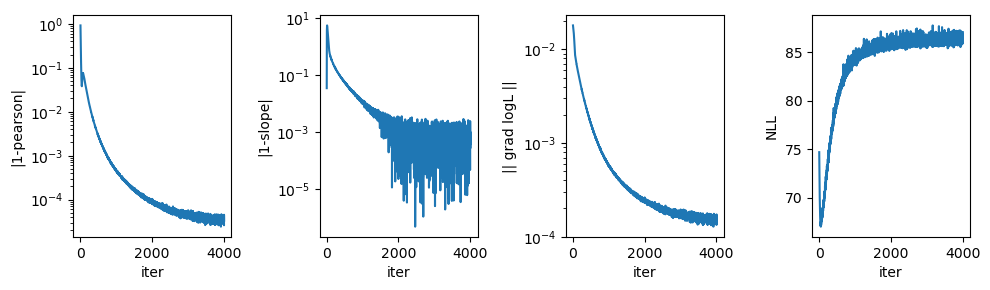

In [69]:
callbacks[0].plot();

In [70]:
with open("../Aptamer2025/notebooks/ab_indep.txt", encoding='utf-8', newline='\n') as file:
    h_reshaped_ab_str = file.read().splitlines()
h_reshaped_ab = [float(h) for h in h_reshaped_ab_str]

In [71]:
h_ab = torch.Tensor(h_reshaped_ab).reshape(q, L).t()

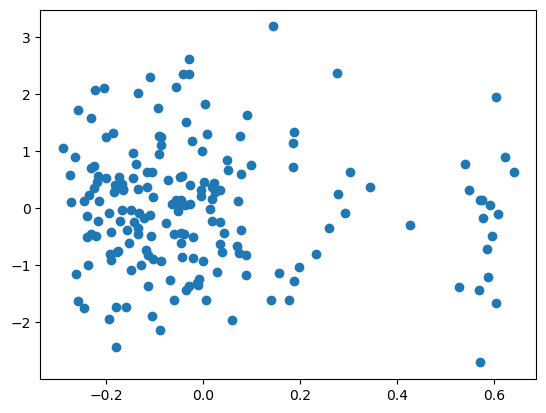

In [72]:
h = model.selection.modes[0].h.detach()
h -= h.mean(1, keepdim=True)
plt.scatter(h, h_ab)

In [73]:
x = torch.tensor([1.5302, 0.9738, 1.3626, 1.1580])
x /= x.sum()
x

tensor([0.3045, 0.1938, 0.2712, 0.2305])